# Анализ данных (EDA)

In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [2]:
#Загрузка 2-х датасетов
df_80 = pd.read_csv("churn-bigml-80.csv", sep = ",")
df_20 = pd.read_csv("churn-bigml-20.csv", sep = ",")
df = pd.concat([df_80, df_20], ignore_index=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [4]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Проверка на соотношение между оставшимися и ушедшими клиентами 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


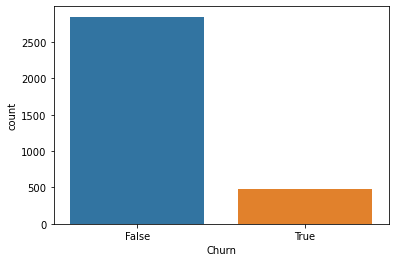

In [5]:
g = sns.countplot(df['Churn'])
g.set_xticklabels([False, True])
plt.show()

In [6]:
#Вывод: 
#  -присутствует дисбаланс классов, т.к. по целевой функции кол-во значений различается больше чем в 5 раз
#  -устранение дисбаланса классов предлагается осуществить методом "Random Over-Sampling"

## Profile_report

In [7]:
#оценим данные через profile_report
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
#Выводы:
# -в датасете 15 колонок с числовыми значениями, 2 - с категориальными, 3 - булево
# -две колонки содержат большое количество нулей: "Number vmail messages" и "Customer service calls" - 
#  принимаем это за норму, если пользователь не звонит, значит у него все ок
# -несколько колонок с высокой кореляцией - для модели логистической регрессии часть из них нужно будет удалить
# -также все нечисловые данные должны быть переведены в числовые для работы модели логистической регрессии

## Оценка пропусков значений

<AxesSubplot:>

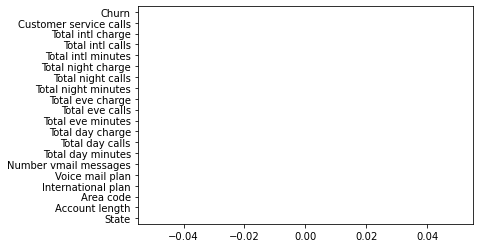

In [9]:
df.isna().sum().plot.barh()

In [10]:
#Пропусков значений в датасете нет

## Категориальные переменные

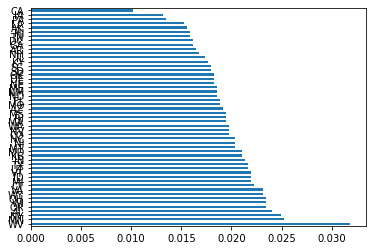

In [11]:
#Колонка "State": количество записей
df.State.value_counts(normalize=True).plot.barh()
plt.show()

In [12]:
#Колонка "State": количество уникальных значений
df['State'].nunique()

51

In [13]:
#Колонка "State": подсчет процентного значения оттока в рамках каждого штата
df_churn_by_state=df.groupby('State')[['Churn']].agg(['sum']).sort_values([('Churn', 'sum')], ascending=False).iloc[:,:1]
df_count_values_by_state=df.groupby('State')[['Churn']].agg(['sum', 'size']).sort_values([('Churn', 'sum')], ascending=False).iloc[:,1:]
df_norm=df_churn_by_state/df_count_values_by_state.values[0,:]

In [14]:
#Топ 5 штатов с максимальным оттоком клиентов
df_norm[:5]

,Churn
,sum
State,
NJ,0.264706
TX,0.264706
MD,0.250000
MI,0.235294
MN,0.220588


In [15]:
#Топ 5 штатов с минимальным оттоком клиентов
df_norm[-5:]

,Churn
,sum
State,
LA,0.058824
AZ,0.058824
HI,0.044118
IA,0.044118
AK,0.044118


In [16]:
#Выводы:
# -по колонке "State" значения распределены практически равномерно по всем категориям.
# -большое количество уникальных значений (51)
# -в процентном соотношении количество оттоков клиентов серьезно различается: от минимальных 4% в штате AK,
#  до максимальных 26% в штате NJ
# -требуется выделить в отдельную категорию штаты с высоким оттоком клиентов для изучения причин высоких значений оттока

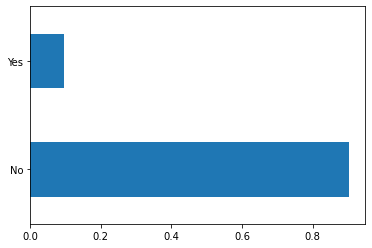

In [17]:
#Колонка "International plan": количество записей
df['International plan'].value_counts(normalize=True).plot.barh()
plt.show()

In [18]:
#Колонка "International plan": подсчет процентного значения оттока в рамках тарифного плана
df_churn_by_International_plan=df.groupby('International plan')[['Churn']].agg(['sum']).sort_values([('Churn', 'sum')], ascending=False).iloc[:,:1]
df_count_values_by_International_plan=df.groupby('International plan')[['Churn']].agg(['sum', 'size']).sort_values([('Churn', 'sum')], ascending=False).iloc[:,1:]
df_churn_by_International_plan/df_count_values_by_International_plan.values[0,:]

,Churn
,sum
International plan,
No,0.114950
Yes,0.045515


In [19]:
#Выводы:
# -большинство клиентов не используют "International plan"
# -отток клиентов, не использующих "International plan", в два раза выше, чем отток клиентов, использующих "International plan"
# -необходимо продвигать использование "International plan"

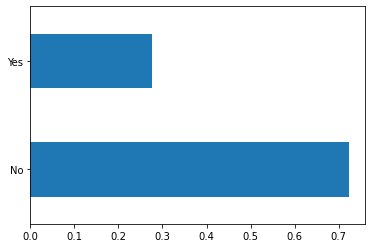

In [20]:
#Колонка "Voice mail plan": количество записей
df['Voice mail plan'].value_counts(normalize=True).plot.barh()
plt.show()

In [21]:
#Колонка "Voice mail plan": подсчет процентного значения оттока в рамках тарифного плана
df_churn_by_International_plan=df.groupby('Voice mail plan')[['Churn']].agg(['sum']).sort_values([('Churn', 'sum')], ascending=False).iloc[:,:1]
df_count_values_by_International_plan=df.groupby('Voice mail plan')[['Churn']].agg(['sum', 'size']).sort_values([('Churn', 'sum')], ascending=False).iloc[:,1:]
df_churn_by_International_plan/df_count_values_by_International_plan.values[0,:]

,Churn
,sum
Voice mail plan,
No,0.167151
Yes,0.033181


In [22]:
#Выводы:
# -большинство клиентов не используют "Voice mail plan"
# -отток клиентов, не использующих "Voice mail plan", в 5(!) раз выше, чем отток клиентов, использующих "Voice mail plan"
# -необходимо продвигать использование "Voice mail plan"

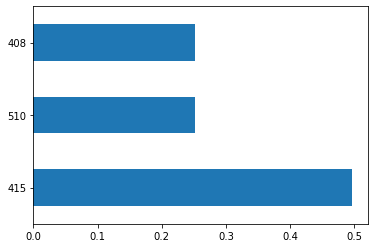

In [23]:
#Колонка "Area code": количество записей
df['Area code'].value_counts(normalize=True).plot.barh()
plt.show()

In [24]:
#Колонка "Area code": подсчет процентного значения оттока в рамках тарифного плана
df_churn_by_Area_code=df.groupby('Area code')[['Churn']].agg(['sum']).sort_values([('Churn', 'sum')], ascending=False).iloc[:,:1]
df_count_values_by_Area_code=df.groupby('Area code')[['Churn']].agg(['sum', 'size']).sort_values([('Churn', 'sum')], ascending=False).iloc[:,1:]
df_churn_by_Area_code/df_count_values_by_Area_code.values[0,:]

,Churn
,sum
Area code,
415,0.142598
510,0.075529
408,0.073716


In [25]:
#Выводы:
# -Для "Area code"=415 отток клиентов в два раза выше, чем по другим значениям, что требует дополнительного изучения

## Перевод нечисловых значений в числовые

In [26]:
#Мэппим целевую функцию на 0 и 1
df['Churn_num']=df['Churn'].map({False: 0, True: 1})

#Мэппим "International plan" и "Voice mail plan" на 0 и 1
df['International plan_num']=df['International plan'].map({'No':0, 'Yes':1})
df['Voice mail plan_num']=df['Voice mail plan'].map({'No':0, 'Yes':1})

#Мэппим "State" на количество записей по значению
df['State_num']=df['State'].map(df['State'].value_counts())

In [27]:
#Удаляем нечисловые колонки
df = df.drop(['Churn', 'International plan', 'Voice mail plan', 'State'], axis=1)

In [28]:
df.describe()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn_num,International plan_num,Voice mail plan_num,State_num
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914,0.096910,0.276628,67.442244
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067,0.295879,0.447398,11.886394
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,0.000000,0.000000,61.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000,0.000000,0.000000,66.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000,0.000000,1.000000,73.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000,1.000000,1.000000,106.000000


In [29]:
#Выводы:
# -Колонки, по которым значение средней и медианы близки, а значит распределение нормальное: "Account length",
#  "Total day minutes", "Total day calls", "Total eve minutes", "Total eve calls", "Total night minutes", "Total night calls",
#  "Total intl minutes", "State_num"

## Корреляция

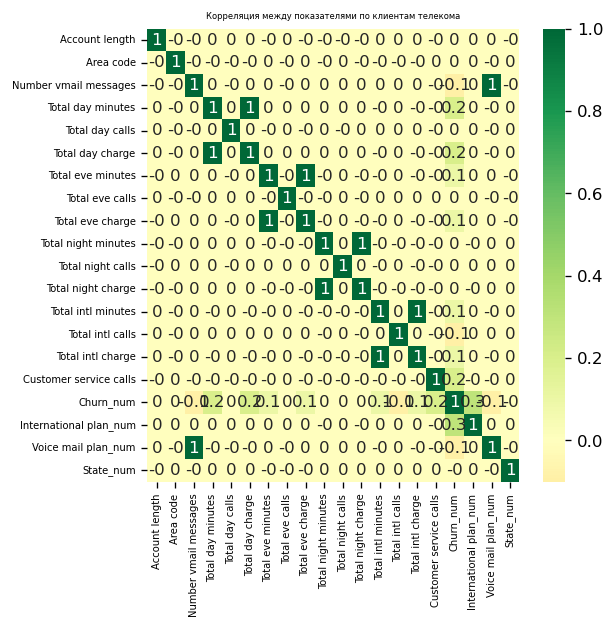

In [30]:
plt.figure(figsize=(5,5), dpi= 120)
sns.heatmap(round(df.corr(),1), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.title('Корреляция между показателями по клиентам телекома', fontsize=5)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

In [31]:
#Выводы:
# -высокая корреляция между "Total day minutes" и "Total day charge",
# "Total eve minutes" и "Total eve charge", "Total night minutes" и "Total night charge",
# "Total intl minutes" и "Total intl charge", "Voice mail plan_num" и "Number vmail messages"
# -корреляция равная единице означает функциональную связь между показателями, скоррее всего применяется поминутная тарификация
# -нет ярковыраженных переменных с высокой корреляцией на показатель оттока пользователей
# -есть показатели с чуть большей корреляцией на показатель оттока клиентов: "Number vmail messages" (-),
#  "Total day minutes" (++), "Total eve minutes" (+), "Total intl minutes" (+), "Total intl calls" (-),
#  "Customer service calls" (++), "International plan_num" (++)

In [32]:
#Удаляем колонки с высокой корреляцией для того чтобы не было переобучения в модели логистической регрессии
df = df.drop(['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge', 'Voice mail plan_num'], axis=1)

## Взаимосвязь переменных 

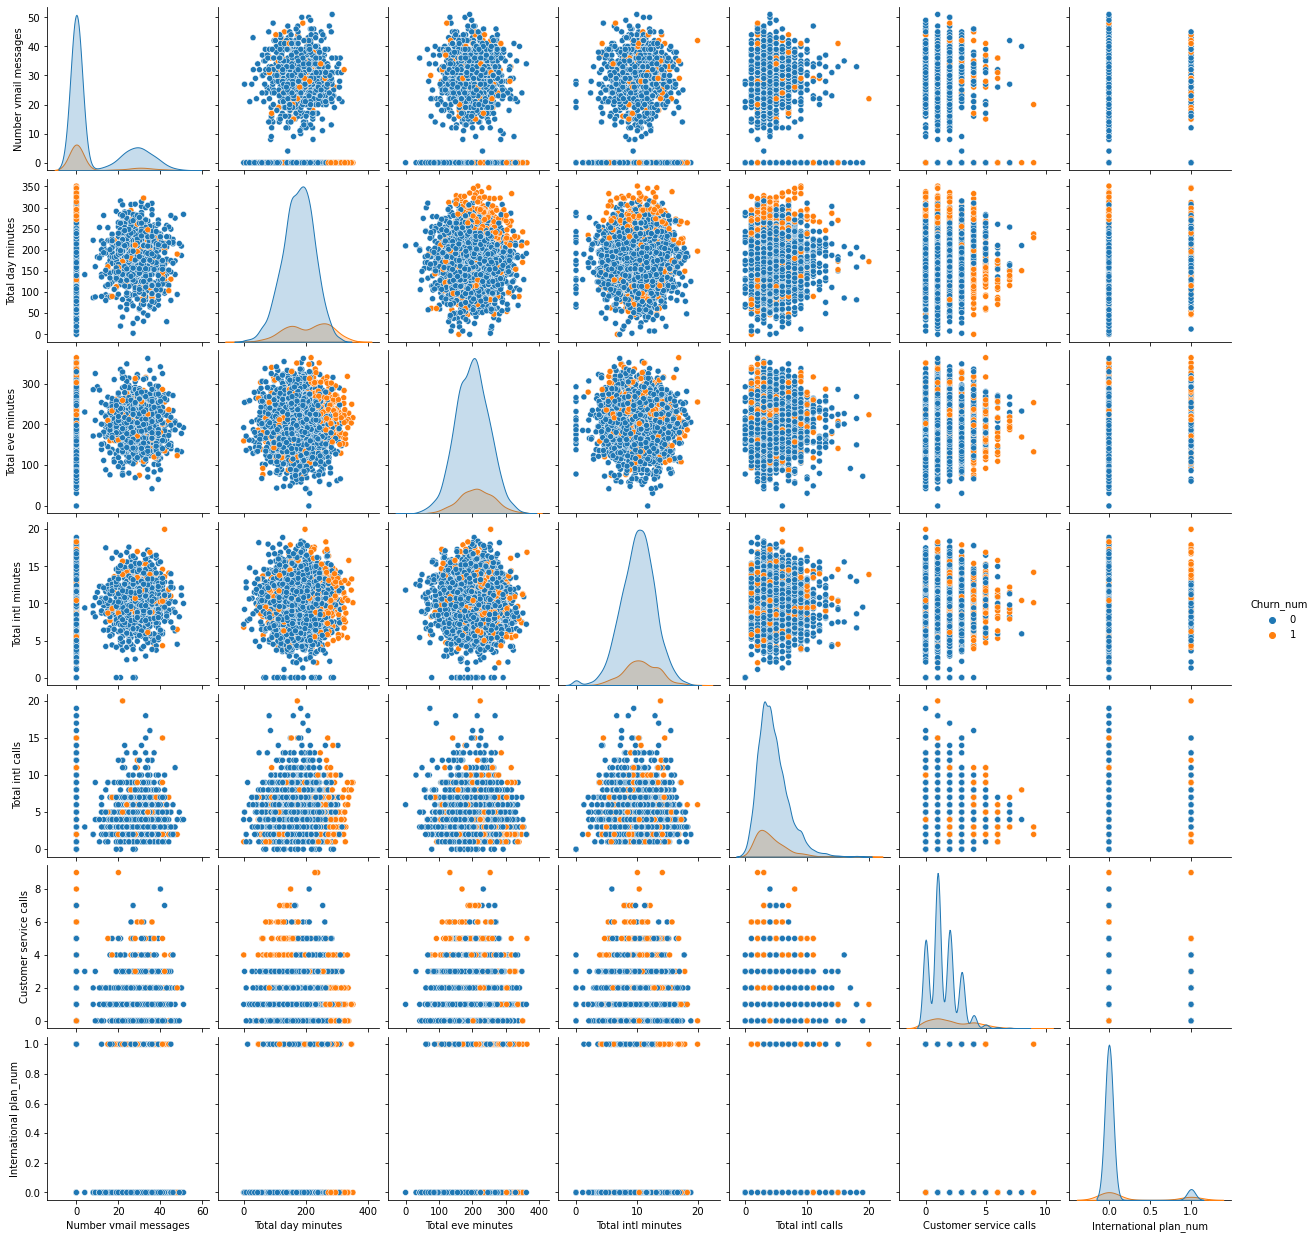

In [33]:
#Построим графики взаимосвязей наиболее коррелирующих между собой показателей и показателем оттока клиентов
sns.pairplot(data = df, vars=['Number vmail messages', 'Total day minutes','Total eve minutes','Total intl minutes',
                              'Total intl calls', 'Customer service calls', 'International plan_num'],hue='Churn_num')
plt.show()

In [34]:
#Выводы:
# -по "Total day minutes" однозначно большее количество минут за день означает больший отток клиентов
# -по "Total day minutes" четко выраженное нормальное распределение по оставшимся клиентам и двугорбое по выбывающим 
# -по "Customer service calls" также большее количество звонков в сервис-центр означает больший отток клиентов
# -нужно в дальнейшем изучать клиентов  с высокими показателями по "Total day minutes" и "Customer service calls",
#  т.к. они потенциально более склонны к уходу

# Формирование модели логистической регрессии

## Устранение дисбаланса классов

In [35]:
#Подсчитаем количество значений в каждом классе, а также разобьем датасет на два
#с нулевым и единичным значением по целевой функции:
class_count_0, class_count_1 = df['Churn_num'].value_counts()
class_0 = df[df['Churn_num'] == 0]
class_1 = df[df['Churn_num'] == 1]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


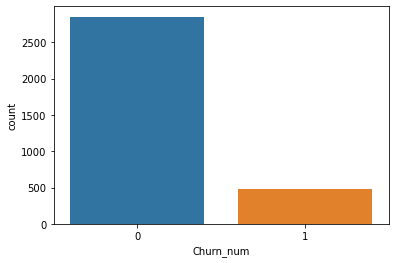

In [36]:
#Графическое соотношение классов
graf = sns.countplot(df['Churn_num'])
graf.set_xticklabels(['0','1'])
plt.show()

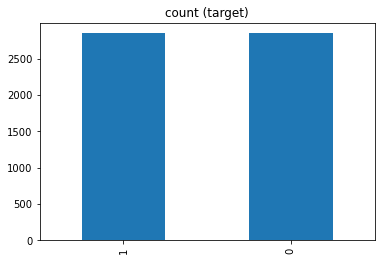

In [37]:
#Просемплируем класс со значениями по целевой функции равными 1 по количеству значений из целевой функции равных 0:
class_1_over = class_1.sample(class_count_0, replace=True)

df_test = pd.concat([class_1_over, class_0], axis=0)

df_test['Churn_num'].value_counts().plot(kind='bar', title='count (target)');

## Подготовка данных

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

In [39]:
#Определяем условия и результат по обучающей выборке
X = df_test.drop(columns = ['Churn_num'])
y = df_test[['Churn_num']]
cols = X.columns

In [40]:
#Проведем z-нормализацию
scaler = StandardScaler()
X_z = pd.DataFrame(scaler.fit_transform(X))
X_z.columns = cols

In [41]:
X_z

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,International plan_num,State_num
0,-0.505708,-0.530123,-0.532032,2.139472,-2.548085,0.604349,-0.930227,-0.289878,-1.121939,0.938164,0.248538,-1.148699,-0.479347,0.914831
1,0.804398,1.704271,-0.532032,1.661791,1.952326,0.354344,0.030077,0.564456,0.447697,0.866841,-0.142482,0.111664,-0.479347,0.226659
2,0.678426,-0.694763,-0.532032,0.582586,1.420019,1.897341,-1.486193,-0.210167,-0.919405,-1.772084,1.030577,-0.518518,-0.479347,0.484724
3,0.048568,1.704271,2.212940,-1.680368,-0.418858,-0.706221,0.484958,-0.717044,-1.020672,0.153618,0.248538,2.632389,-0.479347,0.398702
4,0.350900,-0.530123,-0.532032,1.523473,1.178062,0.004729,-1.334566,-0.212211,2.067966,-1.272828,0.639557,-0.518518,-0.479347,-0.117427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,0.325706,-0.530123,1.450448,-0.877799,-0.612424,-0.971851,1.243093,0.936438,-0.311804,0.367585,1.030577,0.111664,-0.479347,0.914831
5696,0.124151,-0.694763,1.679196,-1.738268,1.468411,-0.030428,1.546347,0.566500,-1.375106,-0.844894,-0.533502,-0.518518,-0.479347,1.086874
5697,-1.034790,-0.530123,-0.532032,0.035746,0.839321,-2.352735,0.484958,0.169991,1.713532,0.973825,1.421596,0.741845,-0.479347,0.484724
5698,1.459451,-0.530123,-0.532032,-0.351867,0.645755,-0.151524,0.232246,-0.165202,-0.919405,0.403246,-0.142482,-0.518518,-0.479347,3.323434


In [42]:
#Определим обучающий и тестовые датасеты
X_train, X_test, y_train, y_test = train_test_split(X_z, y, test_size=0.3, random_state=123)

In [43]:
#Обучим модель
Churn_log_reg = LogisticRegression(solver="liblinear", random_state = 100).fit(X_train, y_train.values.ravel())

## Оценка качества модели

In [44]:
#Зададим функцию для графического представления о качестве модели
def apply_classifier(clf,xTrain,xTest,yTrain,yTest):
    
    clf.fit(xTrain, yTrain)
    predictions = clf.predict(xTest)
    conf_mtx = confusion_matrix(yTest,predictions)
    f, axes = plt.subplots(ncols=2, figsize=(15, 5))
    sns.heatmap(conf_mtx,annot=True,cmap='tab20c',cbar = False,fmt = "g",ax = axes[0])
    axes[0].set_xlabel('Predicted labels')
    axes[0].set_ylabel('True labels')
    axes[0].set_title('Confusion Matrix'); 
    axes[0].xaxis.set_ticklabels(['Not Churn', 'Churn']);
    axes[0].yaxis.set_ticklabels(['Not Churn', 'Churn']);

    print("\n Classification report : \n {}".format(classification_report(yTest,predictions)))
    
    roc_auc = roc_auc_score(yTest,predictions) 
    print ("Area under ROC curve : ",roc_auc,"\n")

    fpr, tpr,_ = roc_curve(yTest, predictions)
    axes[1].plot(fpr,tpr,label= "auc="+str(roc_auc));
    axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")


 Classification report : 
               precision    recall  f1-score   support

           0       0.75      0.76      0.76       863
           1       0.76      0.75      0.75       847

    accuracy                           0.76      1710
   macro avg       0.76      0.76      0.76      1710
weighted avg       0.76      0.76      0.76      1710

Area under ROC curve :  0.7554684860067774 



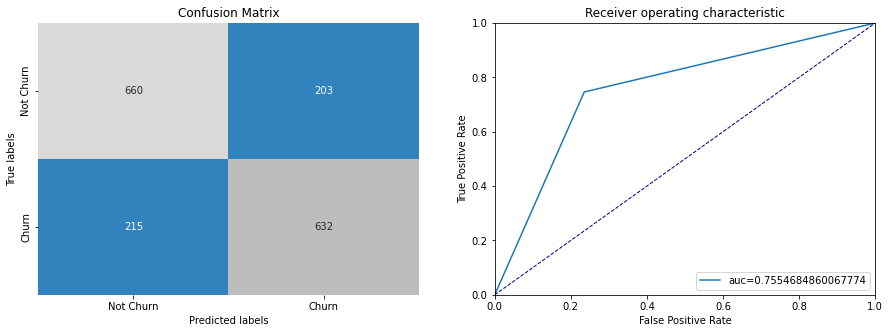

In [45]:
apply_classifier(Churn_log_reg,X_train, X_test, y_train.values.ravel(), y_test)

In [46]:
#Выводы: модель достаточно хорошо предсказывает как отток, так и неотток клиентов (>76% верных результатов)

In [51]:
#Выведем коэффициенты логистической модели
Churn_log_reg.coef_

array([[ 0.01197029, -0.02187665, -0.29928431,  0.83160392,  0.03372694,
         0.31046109,  0.03056213,  0.13195694,  0.01020816,  0.22559818,
        -0.14975752,  0.94432842,  0.95450642, -0.04193886]])

In [48]:
cols

Index(['Account length', 'Area code', 'Number vmail messages',
       'Total day minutes', 'Total day calls', 'Total eve minutes',
       'Total eve calls', 'Total night minutes', 'Total night calls',
       'Total intl minutes', 'Total intl calls', 'Customer service calls',
       'International plan_num', 'State_num'],
      dtype='object')

In [49]:
pd.DataFrame(Churn_log_reg.coef_[0],
cols,
columns=['coef']).sort_values(by='coef', ascending=False)

,coef
International plan_num,0.954506
Customer service calls,0.944328
Total day minutes,0.831604
Total eve minutes,0.310461
Total intl minutes,0.225598
Total night minutes,0.131957
Total day calls,0.033727
Total eve calls,0.030562
Account length,0.011970
Total night calls,0.010208


In [80]:
#Выводы: 
# -наибольшее положительное влияние на показатель оттока оказывает "Total day minutes" и "International plan_num".
# -наибольшее отрицательное влияние "Number vmail messages" и "Total intl calls"

In [47]:
#Используем другой метод чтобы повысить точность предсказания модели
from sklearn.ensemble import AdaBoostClassifier


 Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       863
           1       0.98      1.00      0.99       847

    accuracy                           0.99      1710
   macro avg       0.99      0.99      0.99      1710
weighted avg       0.99      0.99      0.99      1710

Area under ROC curve :  0.988412514484357 



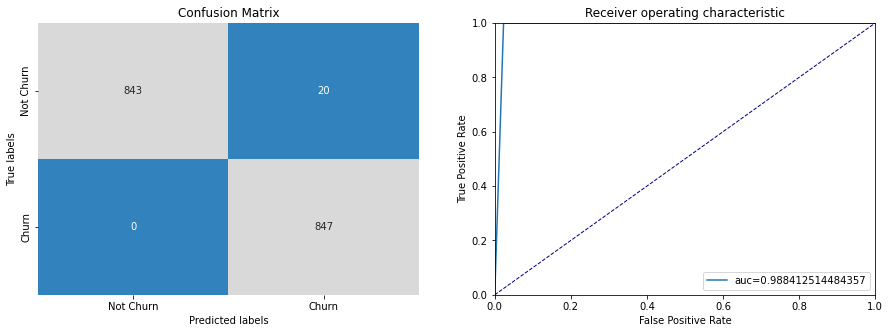

In [48]:
random_forest = RandomForestClassifier(random_state = 100)
model = AdaBoostClassifier(base_estimator = random_forest, n_estimators = 4)
apply_classifier(model,X_train, X_test, y_train.values.ravel(), y_test)

In [49]:
#Выводы: новый метод позволил существенно улучшить точность предсказания: ошибка FP уменьшена в ~100 раз, ошибка FN - в ~10 раз 